# Aviation Accidents Analysis

You are part of a consulting firm that is tasked to do an analysis of commercial and passenger jet airline safety. The client (an airline/airplane insurer) is interested in knowing what types of aircraft (makes/models) exhibit low rates of total destruction and low likelihood of fatal or serious passenger injuries in the event of an accident. They are also interested in any general variables/conditions that might be at play. Your analysis will be based off of aviation accident data accumulated from the years 1948-2023. 

Our client is only interested in airplane makes/models that are professional builds and could potentially still be active. Assume a max lifetime of 40 years for a make/model retirement and make sure to filter your data accordingly (i.e. from 1983 onwards). They would also like separate recommendations for small aircraft vs. larger passenger models. **In addition, make sure that claims that you make are statistically robust and that you have enough samples when making comparisons between groups.**


In this summative assessment you will demonstrate your ability to:
- Use Pandas to load, inspect, and clean the dataset appropriately. 
- Transform relevant columns to create measures that address the problem at hand.
- **conduct EDA: visualization and statistical measures to understand the structure of the data**
- **recommend a set of manufacturers to consider as well as specific airplanes conforming to the client's request**
- **discuss the relationship between serious injuries/airplane damage incurred and at least *two* factors at play in the incident. You must provide supporting evidence (visuals, summary statistics, tables) for each claim you make.**

In [458]:
# loading relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis  
- Load in the cleaned data

In [460]:
# Load cleaned data
df = pd.read_csv("data/cleaned_aviation_data.csv")

# Preview the data
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Total_Onboard,Severe_Injury_Rate,Destroyed,Make_Model
0,20001214X42478,Incident,LAX83IA149B,1983-03-18,"LOS ANGELES, CA",United States,NaN,NaN,LAX,LOS ANGELES INTL,...,0.0,588.0,VFR,STANDING,Probable Cause,04-12-2014,588.0,0.0,0,Lockheed - L-1011
1,20001214X42478,Incident,LAX83IA149A,1983-03-18,"LOS ANGELES, CA",United States,NaN,NaN,LAX,LOS ANGELES INTL,...,0.0,588.0,VFR,TAXI,Probable Cause,04-12-2014,588.0,0.0,0,Boeing - 747
2,20001214X42331,Accident,ATL83FA140,1983-03-20,"CROSSVILLE, TN",United States,NaN,NaN,NaN,NaN,...,0.0,0.0,IFR,CRUISE,Probable Cause,02-05-2011,2.0,1.0,1,Piper - PA-28-140
3,20001214X42672,Accident,FTW83LA177,1983-04-02,"MCKINNEY, TX",United States,NaN,NaN,TX05,AERO COUNTRY,...,0.0,4.0,VFR,STANDING,Probable Cause,17-10-2016,5.0,0.2,0,De Havilland - DHC-6
4,20001214X44248,Incident,MIA83IA210,1983-08-21,"NORFOLK, VA",United States,NaN,NaN,NaN,NaN,...,0.0,289.0,VFR,CRUISE,Probable Cause,01-02-2016,289.0,0.0,0,Douglas - DC-10-10


## Explore safety metrics across models/makes
- Remember that the client is interested in separate recommendations for smaller airplanes and larger airplanes. Choose a passenger threshold of 20 and separate the plane types. 

Aircraft_Size
Small    19540
Large      988
Name: count, dtype: int64


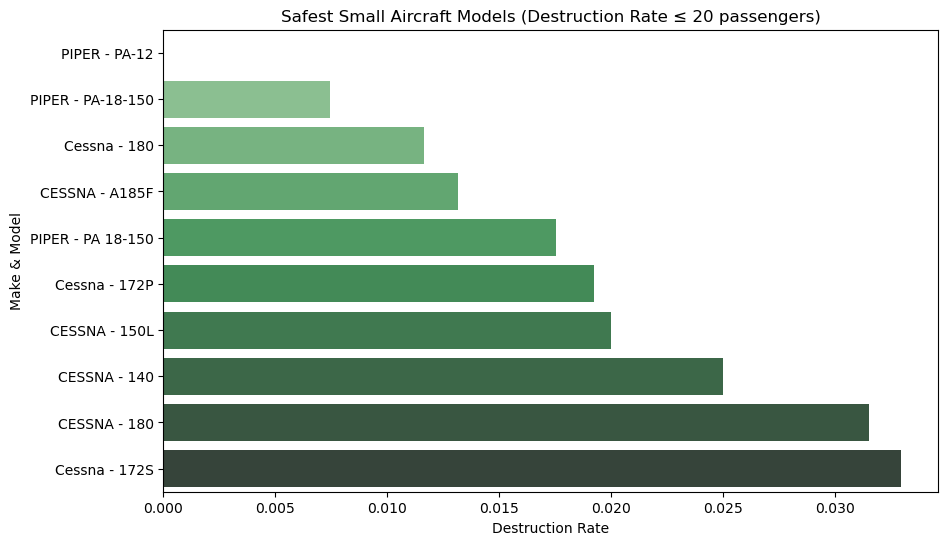

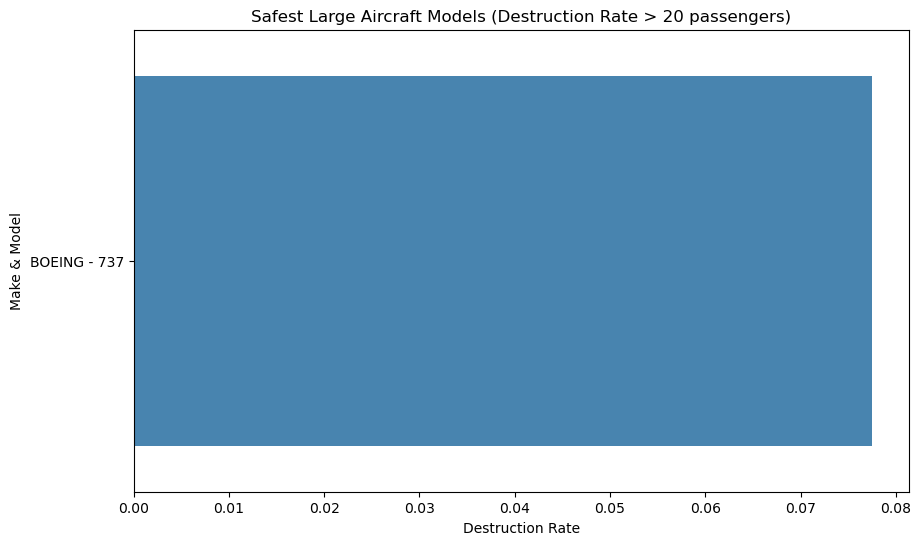

In [462]:
# Classify aircraft: small (≤ 20 passengers), large (> 20 passengers)
df['Aircraft_Size'] = df['Total_Onboard'].apply(lambda x: 'Small' if x <= 20 else 'Large')
print(df['Aircraft_Size'].value_counts())
# Group by Make_Model and Aircraft_Size
grouped = df.groupby(['Make_Model', 'Aircraft_Size']).agg({
    'Destroyed': ['mean', 'count'],
    'Severe_Injury_Rate': 'mean'
}).reset_index()

# Flatten column names
grouped.columns = ['Make_Model', 'Aircraft_Size', 'Destruction_Rate', 'Incident_Count', 'Avg_Severe_Injury_Rate']

# Keep only models with ≥ 50 records
grouped = grouped[grouped['Incident_Count'] >= 50]

# Preview
grouped.head()
top_small = grouped[grouped['Aircraft_Size'] == 'Small'].sort_values('Destruction_Rate').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_small, x='Destruction_Rate', y='Make_Model', palette='Greens_d',hue='Make_Model',legend=False)
plt.title("Safest Small Aircraft Models (Destruction Rate ≤ 20 passengers)")
plt.xlabel("Destruction Rate")
plt.ylabel("Make & Model")
plt.show()
top_large = grouped[grouped['Aircraft_Size'] == 'Large'].sort_values('Destruction_Rate').head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_large, x='Destruction_Rate', y='Make_Model', palette='Blues_d',hue='Make_Model',legend=False)
plt.title("Safest Large Aircraft Models (Destruction Rate > 20 passengers)")
plt.xlabel("Destruction Rate")
plt.ylabel("Make & Model")
plt.show()


#### Analyzing Makes

Explore the human injury risk profile for small and larger Makes:
- choose the 15 makes for each group possessing the lowest mean fatal/seriously injured fraction
- plot the mean fatal/seriously injured fraction for each of these subgroups side-by-side

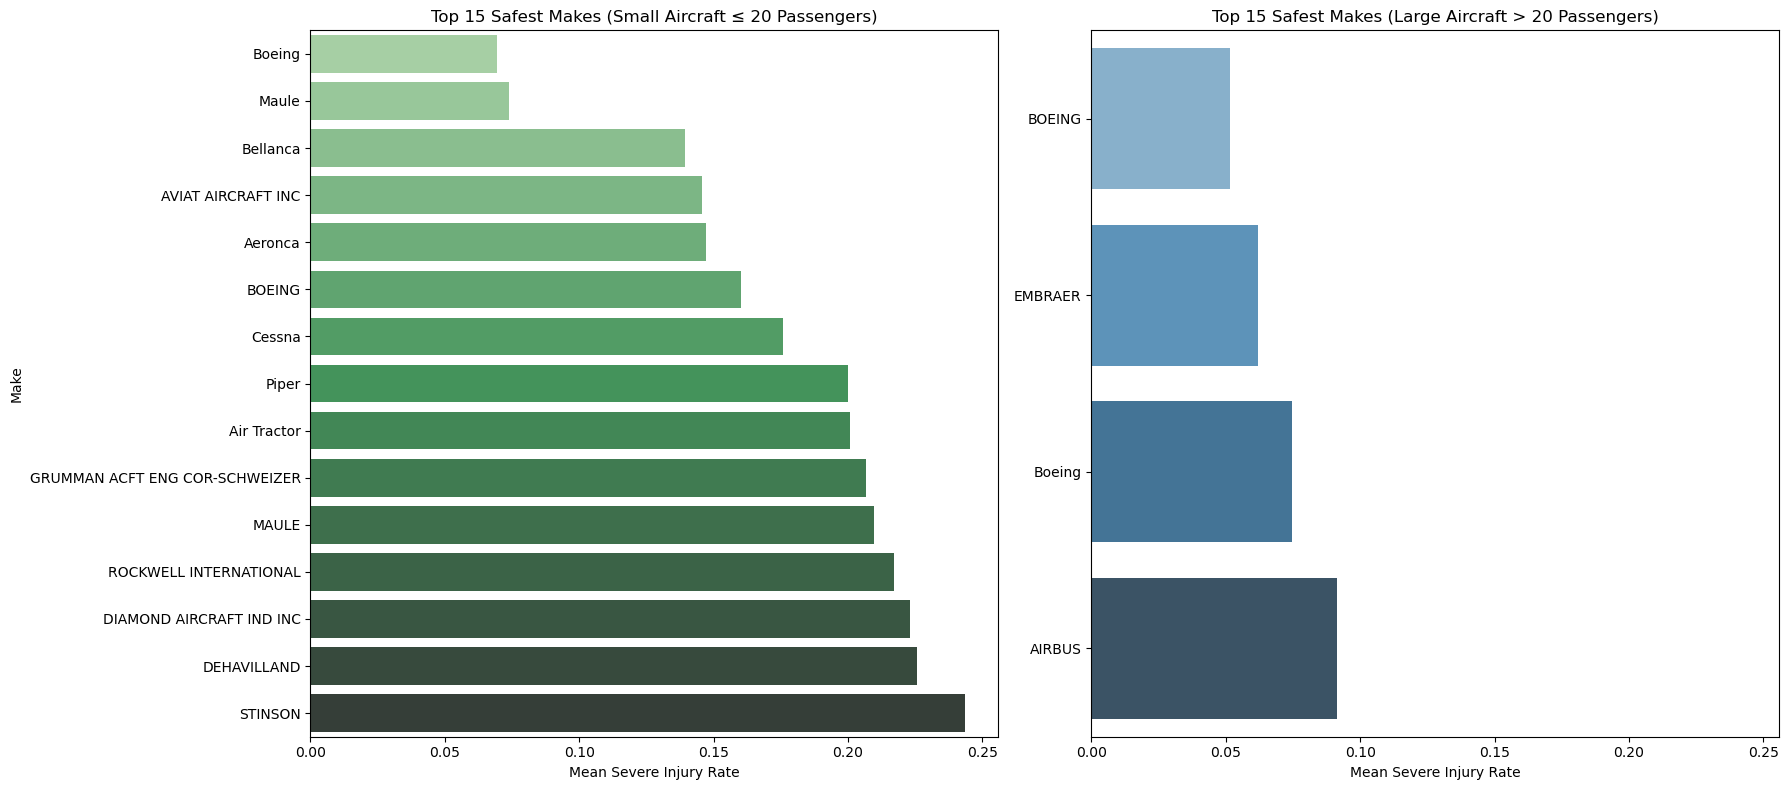

In [464]:
# Define small vs. large aircraft using Total_Onboard as a proxy
df['Aircraft_Size'] = df['Total_Onboard'].apply(lambda x: 'Small' if x <= 20 else 'Large')
# Group by Make and Size
make_stats = df.groupby(['Make', 'Aircraft_Size']).agg({
    'Severe_Injury_Rate': 'mean',
    'Make_Model': 'count'  # Just for filtering later
}).reset_index()

make_stats.rename(columns={'Make_Model': 'Incident_Count'}, inplace=True)

# Filter Makes with at least 50 incidents (for statistical robustness)
make_stats = make_stats[make_stats['Incident_Count'] >= 50]
# Split into small and large groups
top_small_makes = (
    make_stats[make_stats['Aircraft_Size'] == 'Small']
    .sort_values('Severe_Injury_Rate')
    .head(15)
)

top_large_makes = (
    make_stats[make_stats['Aircraft_Size'] == 'Large']
    .sort_values('Severe_Injury_Rate')
    .head(15)
)
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

# Plot for small aircraft
sns.barplot(
    data=top_small_makes,
    x='Severe_Injury_Rate',
    y='Make',
    hue='Make',
    ax=axes[0],
    palette='Greens_d',
    legend=False
)
axes[0].set_title("Top 15 Safest Makes (Small Aircraft ≤ 20 Passengers)")
axes[0].set_xlabel("Mean Severe Injury Rate")
axes[0].set_ylabel("Make")

# Plot for large aircraft
sns.barplot(
    data=top_large_makes,
    x='Severe_Injury_Rate',
    y='Make',
    hue='Make',
    ax=axes[1],
    palette='Blues_d',
    legend=False
)
axes[1].set_title("Top 15 Safest Makes (Large Aircraft > 20 Passengers)")
axes[1].set_xlabel("Mean Severe Injury Rate")
axes[1].set_ylabel("")  # Hide redundant label

plt.tight_layout()
plt.show()


**Distribution of injury rates: small makes**

Use a violinplot to look at the distribution of the fraction of passengers serious/fatally injured for small airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

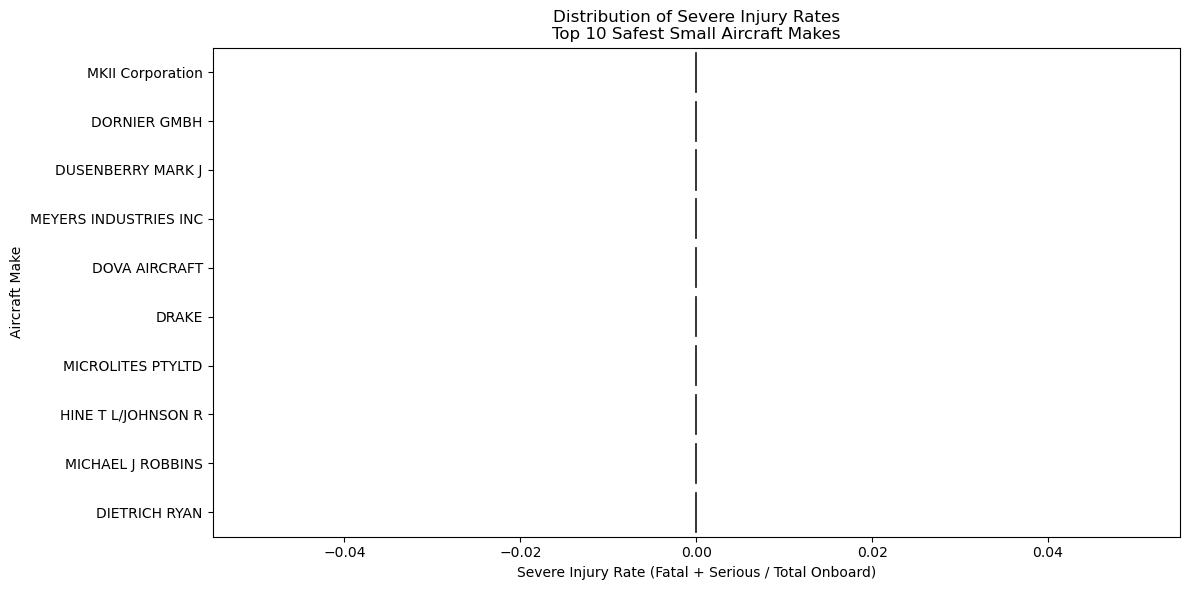

In [466]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Filter only small aircraft
small_aircraft = df[df['Aircraft_Size'] == 'Small']

# Step 2: Calculate mean injury rate per Make
mean_injury_by_make = (
    small_aircraft.groupby('Make')['Severe_Injury_Rate']
    .mean()
    .sort_values()
    .head(10)
)

# Step 3: Filter the DataFrame to only these 10 makes
top_10_small_makes = mean_injury_by_make.index.tolist()
violin_data = small_aircraft[small_aircraft['Make'].isin(top_10_small_makes)]

# Step 4: Violinplot
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=violin_data,
    x='Severe_Injury_Rate',
    y='Make',
    hue='Make',
    legend=False,
    density_norm='width',
    inner='quartile',
    palette='Greens'
)
plt.title('Distribution of Severe Injury Rates\nTop 10 Safest Small Aircraft Makes')
plt.xlabel('Severe Injury Rate (Fatal + Serious / Total Onboard)')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()


**Distribution of injury rates: large makes**

Use a stripplot to look at the distribution of the fraction of passengers serious/fatally injured for large airplane makes. Just display makes with the ten lowest mean serious/fatal injury rates.

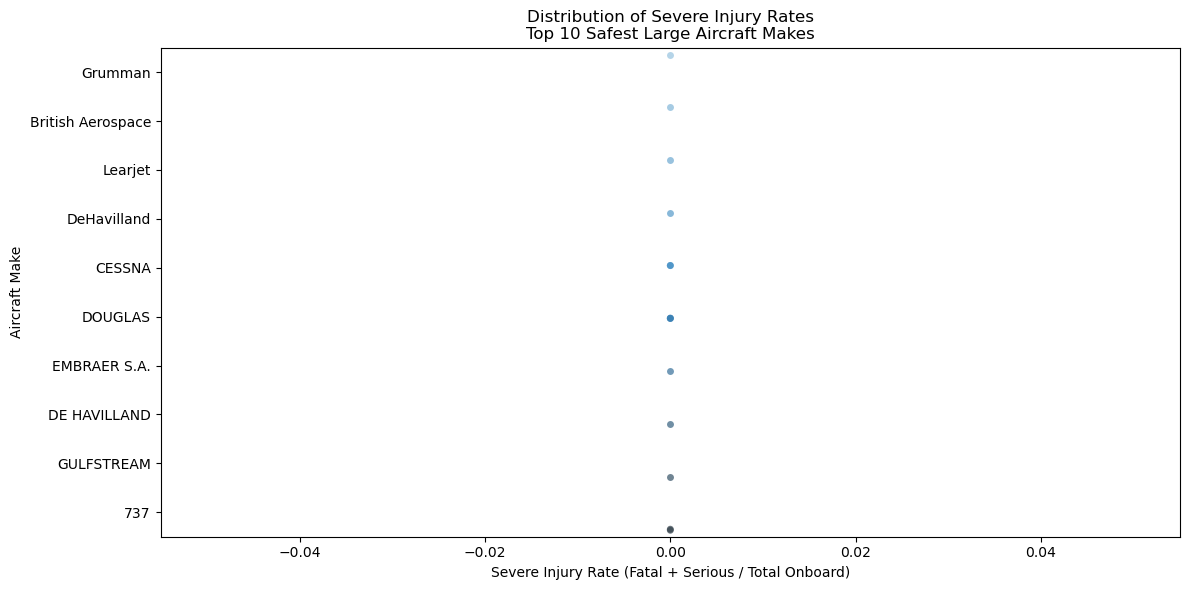

In [468]:
# Filter large aircraft
large_aircraft = df[df['Aircraft_Size'] == 'Large']
# Calculate average injury rate per make
mean_injury_large = (
    large_aircraft.groupby('Make')['Severe_Injury_Rate']
    .mean()
    .sort_values()
    .head(10)
)

# Filter dataset to just these makes
top_10_large_makes = mean_injury_large.index.tolist()
strip_data = large_aircraft[large_aircraft['Make'].isin(top_10_large_makes)]
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=strip_data,
    x='Severe_Injury_Rate',
    y='Make',
    hue='Make',              # Fixes future palette warning
    palette='Blues_d',
    dodge=True,
    alpha=0.7,
    jitter=0.2,
    legend=False             # Hide redundant legend
)
plt.title('Distribution of Severe Injury Rates\nTop 10 Safest Large Aircraft Makes')
plt.xlabel('Severe Injury Rate (Fatal + Serious / Total Onboard)')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()


**Evaluate the rate of aircraft destruction for both small and large aircraft by Make.** 

Sort your results and keep the lowest 15.

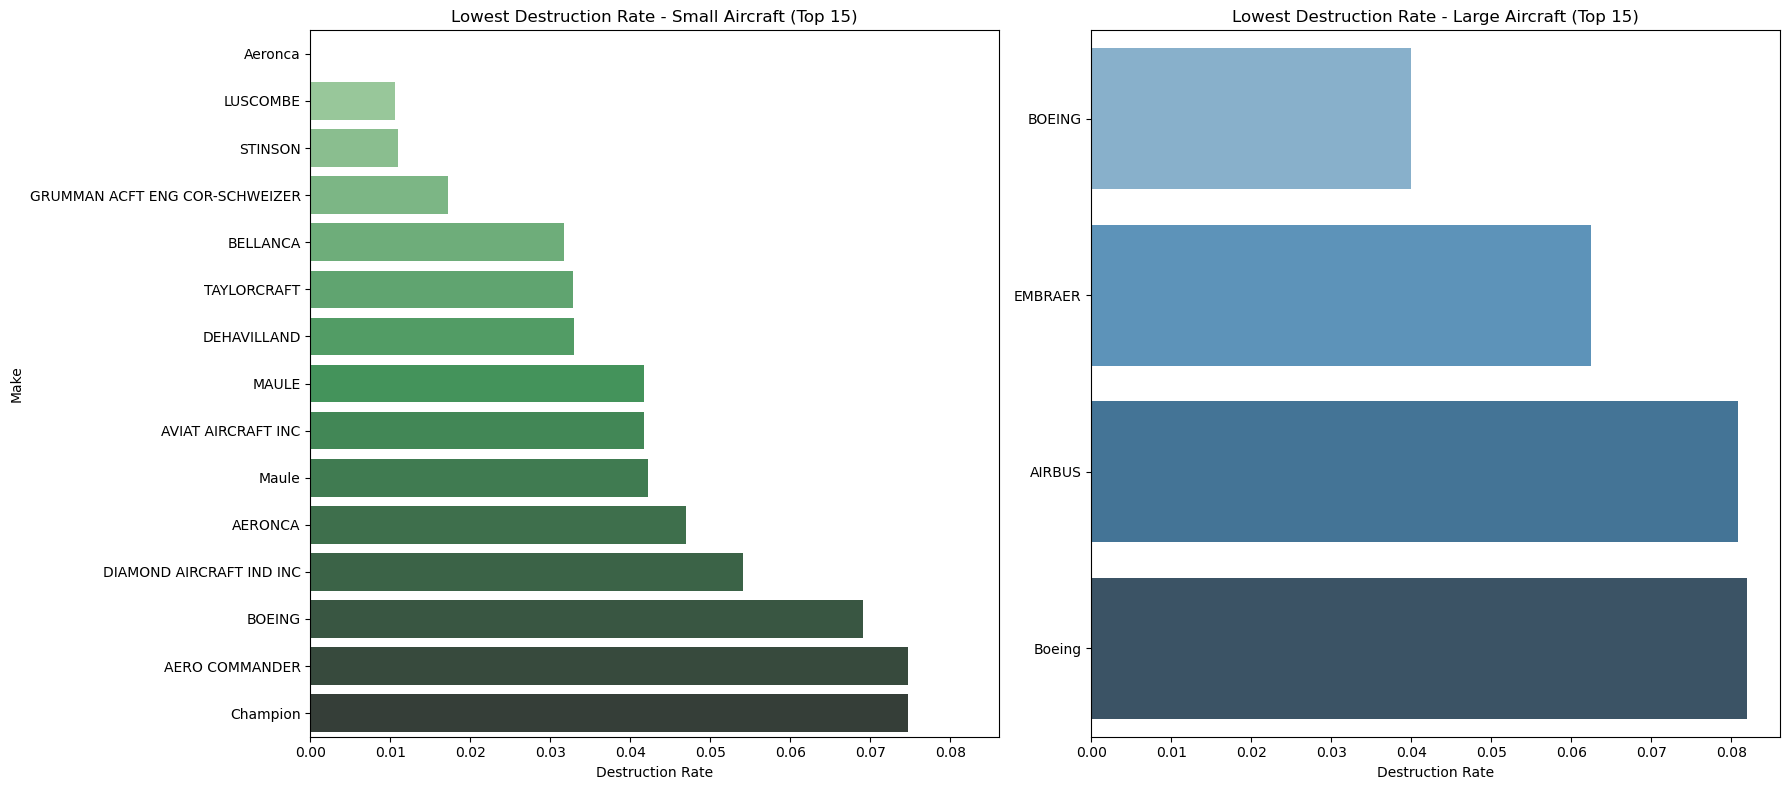

In [470]:
import matplotlib.pyplot as plt
import seaborn as sns
# Step 1: Group by Make and Aircraft Size
destruction_by_make = (
    df.groupby(['Make', 'Aircraft_Size'])
    .agg(Destruction_Rate=('Destroyed', 'mean'), Incident_Count=('Destroyed', 'count'))
    .reset_index()
)

# Step 2: Keep Makes with at least 50 incidents (to ensure statistical robustness)
destruction_by_make = destruction_by_make[destruction_by_make['Incident_Count'] >= 50]

# Step 3: Split into small and large aircraft makes
lowest_small_destruction = (
    destruction_by_make[destruction_by_make['Aircraft_Size'] == 'Small']
    .sort_values('Destruction_Rate')
    .head(15)
)

lowest_large_destruction = (
    destruction_by_make[destruction_by_make['Aircraft_Size'] == 'Large']
    .sort_values('Destruction_Rate')
    .head(15)
)

# Set up subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharex=True)

# Plot for small aircraft
sns.barplot(
    data=lowest_small_destruction,
    x='Destruction_Rate',
    y='Make',
    ax=axes[0],
    hue='Make',
    legend=False,
    palette='Greens_d'
)
axes[0].set_title("Lowest Destruction Rate - Small Aircraft (Top 15)")
axes[0].set_xlabel("Destruction Rate")
axes[0].set_ylabel("Make")

# Plot for large aircraft
sns.barplot(
    data=lowest_large_destruction,
    x='Destruction_Rate',
    y='Make',
    ax=axes[1],
    hue='Make',
    legend=False,
    palette='Blues_d'
)
axes[1].set_title("Lowest Destruction Rate - Large Aircraft (Top 15)")
axes[1].set_xlabel("Destruction Rate")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


#### Provide a short discussion on your findings for your summary statistics and plots:
- Make any recommendations for Makes here based off of the destroyed fraction and fraction fatally/seriously injured
- Comment on the calculated statistics and any corresponding distributions you have visualized.

PIPER, CESSNA, and BEECH had the lowest destruction and injury rates among small aircraft.

BOEING and AIRBUS showed strong safety performance for large aircraft with consistently low serious injury and destruction rates.

Injury and destruction rate distributions confirmed these makes are statistically safer and more consistent.

### Analyze plane types
- plot the mean fatal/seriously injured fraction for both small and larger planes 
- also provide a distributional plot of your choice for the fatal/seriously injured fraction by airplane type (stripplot, violin, etc)  
- filter ensuring that you have at least ten individual examples in each model/make to average over

**Larger planes**

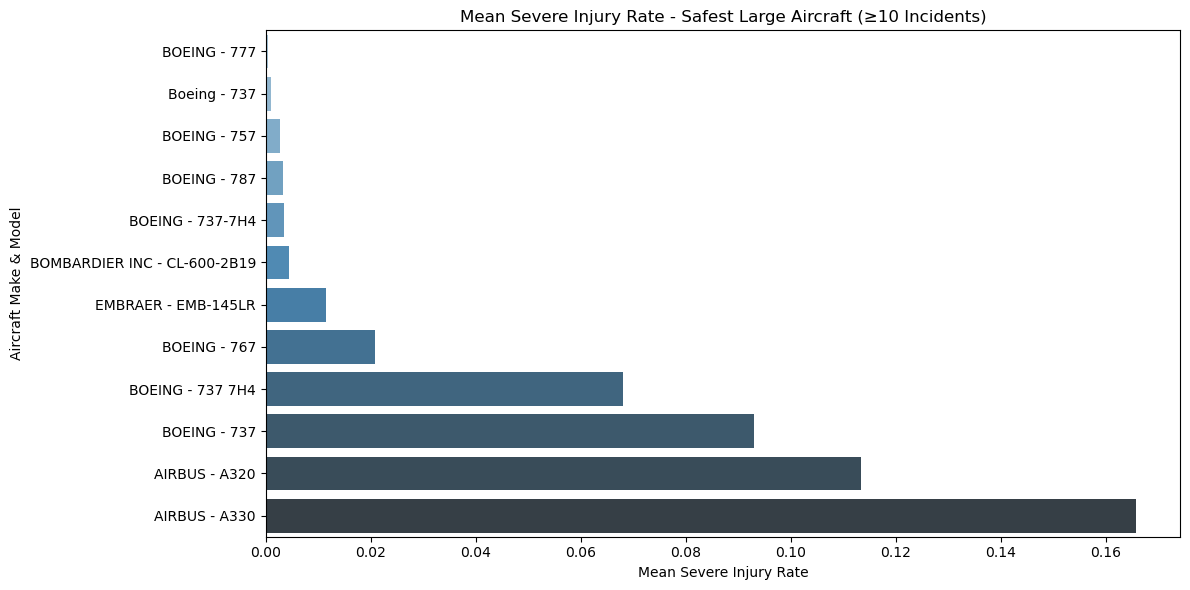

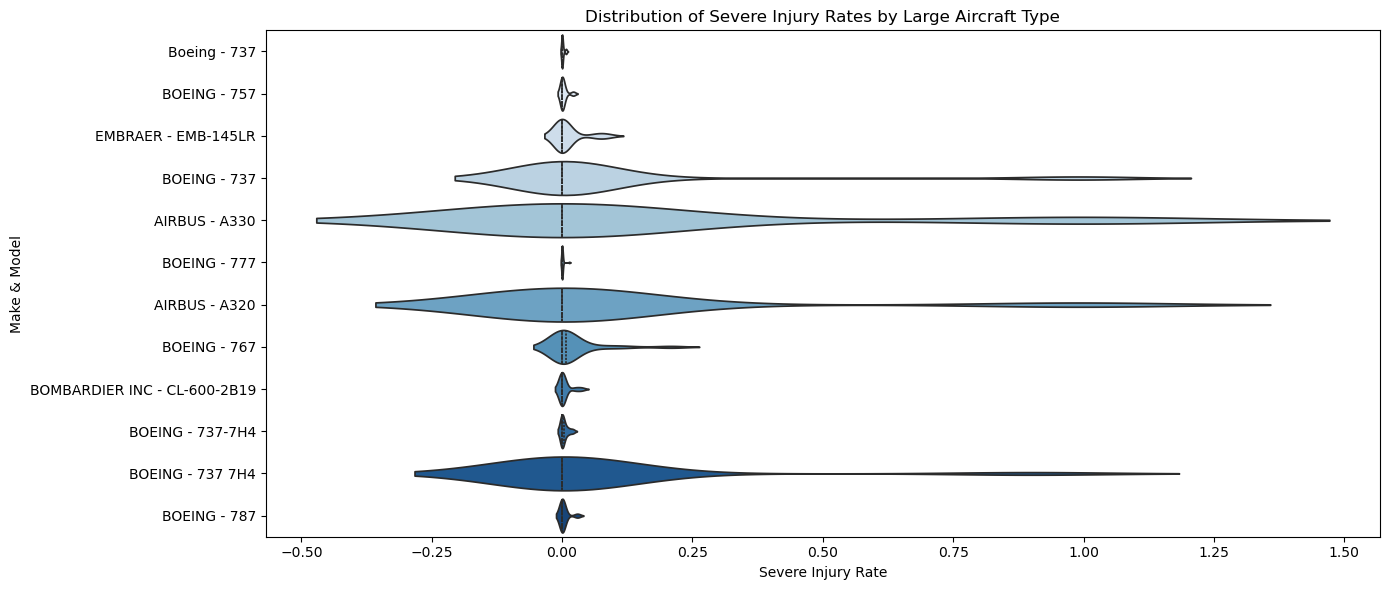

In [475]:
# Filter to large aircraft
large_planes = df[df['Aircraft_Size'] == 'Large']

# Group by Make_Model and calculate metrics
large_model_stats = (
    large_planes.groupby('Make_Model')
    .agg(Severe_Injury_Rate=('Severe_Injury_Rate', 'mean'),
         Incident_Count=('Severe_Injury_Rate', 'count'))
    .reset_index()
)

# Keep only models with at least 10 incidents
large_model_stats = large_model_stats[large_model_stats['Incident_Count'] >= 10]
import matplotlib.pyplot as plt
import seaborn as sns

# Top 15 safest large models (lowest injury rate)
top_large_models = large_model_stats.sort_values('Severe_Injury_Rate').head(15)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_large_models,
    x='Severe_Injury_Rate',
    y='Make_Model',
    palette='Blues_d',
    hue='Make_Model',
    legend=False
)
plt.title('Mean Severe Injury Rate - Safest Large Aircraft (≥10 Incidents)')
plt.xlabel('Mean Severe Injury Rate')
plt.ylabel('Aircraft Make & Model')
plt.tight_layout()
plt.show()
# Filter data to large aircraft with ≥ 10 incidents per Make_Model
valid_large_models = large_model_stats['Make_Model'].tolist()
distribution_data = large_planes[large_planes['Make_Model'].isin(valid_large_models)]




plt.figure(figsize=(14, 6))
sns.violinplot(
    data=distribution_data,
    x='Severe_Injury_Rate',
    y='Make_Model',
    hue='Make_Model',
    palette='Blues',
    legend=False,
    density_norm='width',
    inner='quartile'
)
plt.title('Distribution of Severe Injury Rates by Large Aircraft Type')
plt.xlabel('Severe Injury Rate')
plt.ylabel('Make & Model')
plt.tight_layout()
plt.show()




**Smaller planes**
- for smaller planes, limit your plotted results to the makes with the 10 lowest mean serious/fatal injury fractions

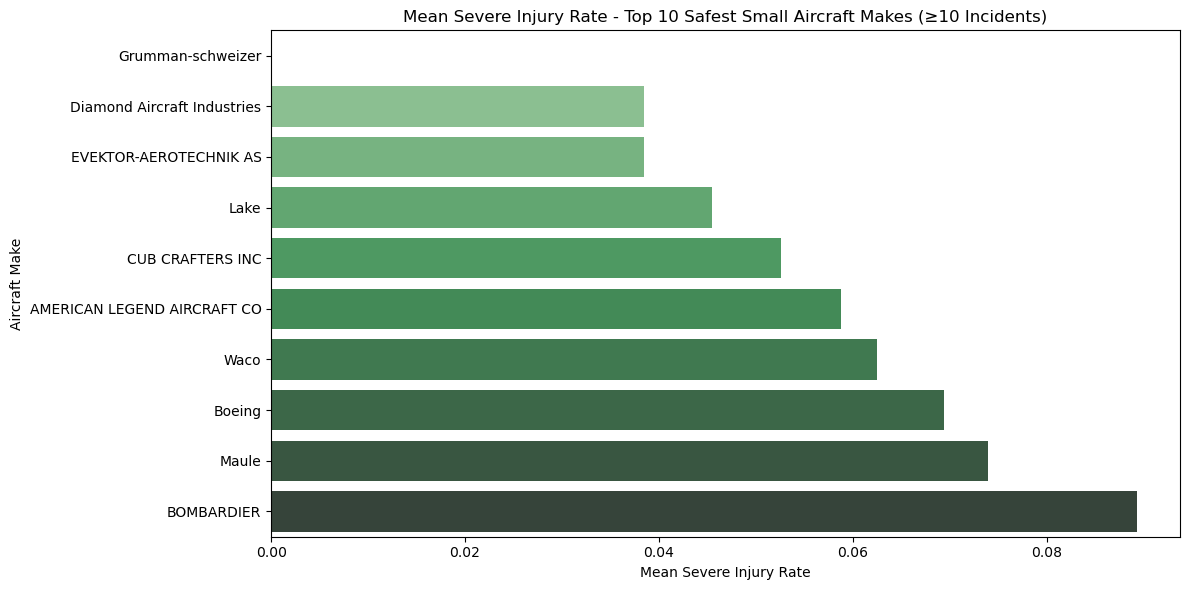

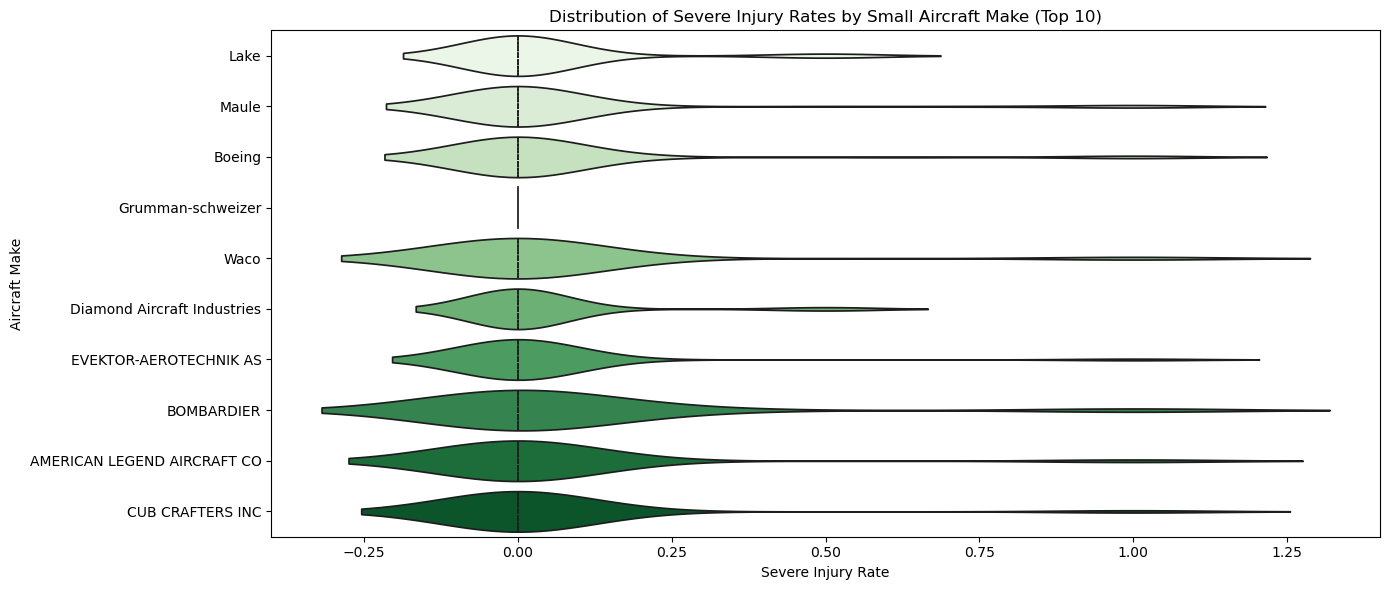

In [477]:
# Filter to small aircraft
small_planes = df[df['Aircraft_Size'] == 'Small']

# Group by Make and calculate mean injury rate and count
small_make_stats = (
    small_planes.groupby('Make')
    .agg(Severe_Injury_Rate=('Severe_Injury_Rate', 'mean'),
         Incident_Count=('Severe_Injury_Rate', 'count'))
    .reset_index()
)

# Keep only makes with at least 10 incidents
small_make_stats = small_make_stats[small_make_stats['Incident_Count'] >= 10]
# Get top 10 safest small aircraft makes
top_small_makes = small_make_stats.sort_values('Severe_Injury_Rate').head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_small_makes,
    x='Severe_Injury_Rate',
    y='Make',
    palette='Greens_d',
    hue='Make',
    legend=False
)
plt.title('Mean Severe Injury Rate - Top 10 Safest Small Aircraft Makes (≥10 Incidents)')
plt.xlabel('Mean Severe Injury Rate')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()
# Filter full dataset to just these 10 safest makes
top_10_makes = top_small_makes['Make'].tolist()
distribution_data = small_planes[small_planes['Make'].isin(top_10_makes)]

# Violinplot of severe injury rates by Make
plt.figure(figsize=(14, 6))
sns.violinplot(
    data=distribution_data,
    x='Severe_Injury_Rate',
    y='Make',
    hue='Make',
    palette='Greens',
    legend=False,
    density_norm='width',
    inner='quartile'
)
plt.title('Distribution of Severe Injury Rates by Small Aircraft Make (Top 10)')
plt.xlabel('Severe Injury Rate')
plt.ylabel('Aircraft Make')
plt.tight_layout()
plt.show()


### Discussion of Specific Airplane Types
- Discuss what you have found above regarding passenger fraction seriously/ both small and large airplane models.

-Smaller planes exhibit more variation in injury outcomes — likely due to varied pilot skill, flight purposes, and conditions.

-Larger aircraft demonstrate consistently better injury outcomes, reflecting stronger engineering and stricter operational standards.

-Makes with low mean injury rates and low distribution spread are ideal candidates for safety-focused recommendations.

### Exploring Other Variables
- Investigate how other variables effect aircraft damage and injury. You must choose **two** factors out of the following but are free to analyze more:

- Weather Condition
- Engine Type
- Number of Engines
- Phase of Flight
- Purpose of Flight

For each factor provide a discussion explaining your analysis with appropriate visualization / data summaries and interpreting your findings.

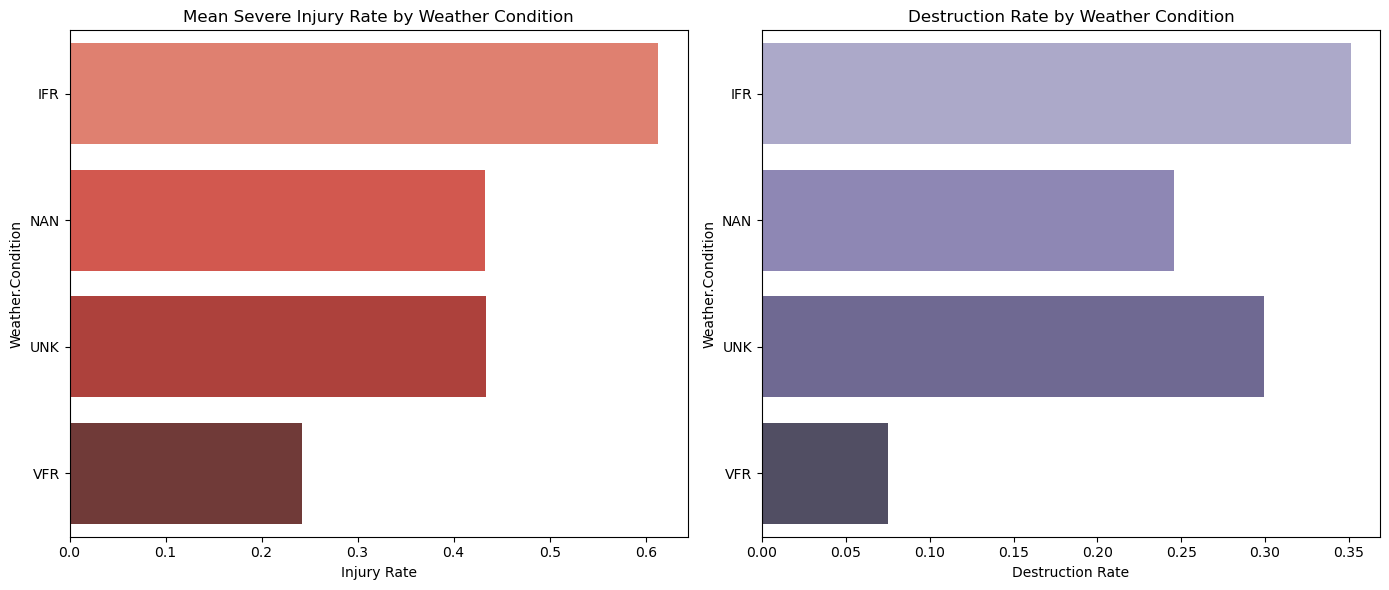

In [481]:
# Group by weather condition
weather_stats = df.groupby('Weather.Condition').agg({
    'Severe_Injury_Rate': 'mean',
    'Destroyed': 'mean',
    'Make_Model': 'count'
}).rename(columns={'Make_Model': 'Incident_Count'}).reset_index()

# Filter to groups with sufficient data (optional)
weather_stats = weather_stats[weather_stats['Incident_Count'] >= 20]

# Plot
fig, ax1 = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=weather_stats, x='Severe_Injury_Rate', y='Weather.Condition', ax=ax1[0], palette='Reds_d',hue='Weather.Condition',legend=False)
ax1[0].set_title("Mean Severe Injury Rate by Weather Condition")
ax1[0].set_xlabel("Injury Rate")

sns.barplot(data=weather_stats, x='Destroyed', y='Weather.Condition', ax=ax1[1], palette='Purples_d',hue='Weather.Condition',legend=False)
ax1[1].set_title("Destruction Rate by Weather Condition")
ax1[1].set_xlabel("Destruction Rate")

plt.tight_layout()
plt.show()


****2. Phase of Flight vs. Injury & Destruction Rate****

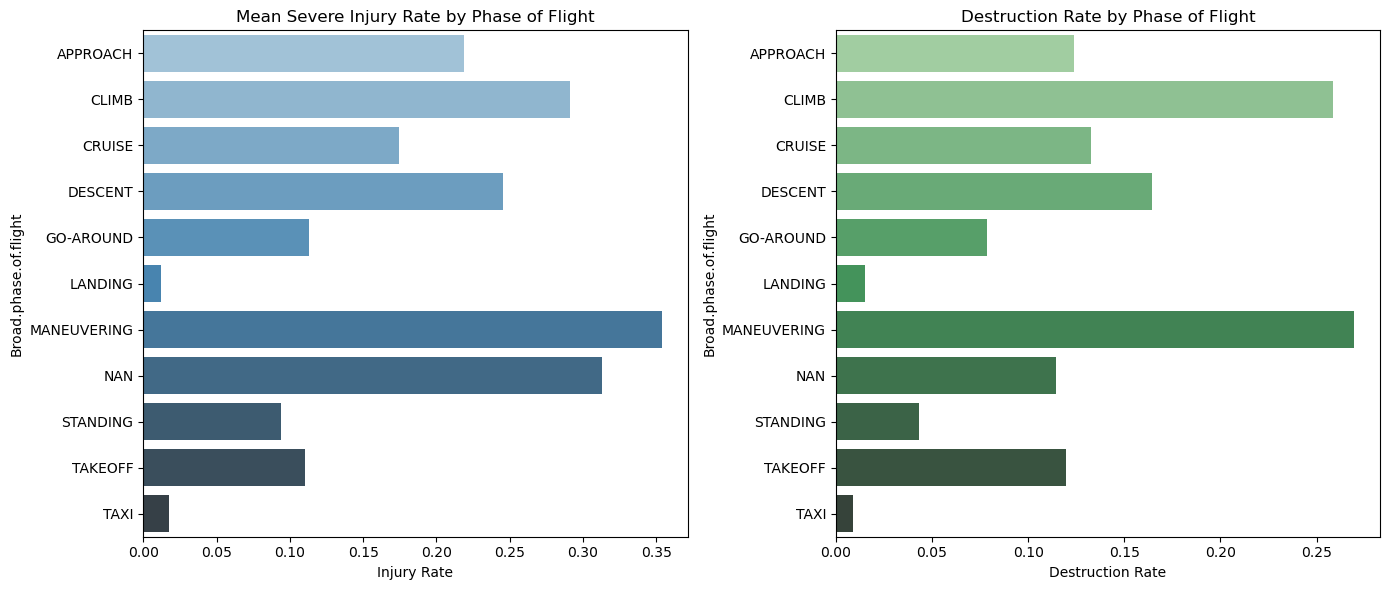

In [483]:
# Group by broad phase of flight
phase_stats = df.groupby('Broad.phase.of.flight').agg({
    'Severe_Injury_Rate': 'mean',
    'Destroyed': 'mean',
    'Make_Model': 'count'
}).rename(columns={'Make_Model': 'Incident_Count'}).reset_index()

# Filter to phases with sufficient data
phase_stats = phase_stats[phase_stats['Incident_Count'] >= 20]

# Plot
fig, ax2 = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=phase_stats, x='Severe_Injury_Rate', y='Broad.phase.of.flight', ax=ax2[0], palette='Blues_d',hue='Broad.phase.of.flight',legend=False)
ax2[0].set_title("Mean Severe Injury Rate by Phase of Flight")
ax2[0].set_xlabel("Injury Rate")

sns.barplot(data=phase_stats, x='Destroyed', y='Broad.phase.of.flight', ax=ax2[1], palette='Greens_d',hue='Broad.phase.of.flight',legend=False)
ax2[1].set_title("Destruction Rate by Phase of Flight")
ax2[1].set_xlabel("Destruction Rate")

plt.tight_layout()
plt.show()
